In [1]:
import sys
sys.path.append('../src')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
from heat3d_np import heat3d_np
from heat3d_cp import heat3d_cp

In [5]:
from heat3d_devito import heat3d_devito
from heat3d_gt4py import heat3d_gt4py

In [6]:
# global const
alpha = 19.
Tcool, Thot = 300., 400.

In [7]:
nx = ny = nz = 8
nt = 8

x = y = z = 2.
dx = dy = dz = x / (nx - 1)

dt = alpha/10000 * (1/dx**2 + 1/dy**2 + 1/dz**2)**(-1)

in_field = Tcool*np.ones((nx,ny,nz))
in_field[nx//4:3*nx//4, ny//4:3*ny//4, nz//4:3*nz//4] = Thot

heat3d_gt4py(in_field, alpha, Tcool, dx, dy, dz, dt, nt, backend='gtcuda', result='time')

0.13631552550941706

In [8]:
def benchmark(nx, nt=nt, gpu=False):
    ny = nx
    nz = nx
    #print(f'{nx} x {ny} x {nz}')
    
    in_field = Tcool*np.ones((nx,ny,nz))
    in_field[nx//4:3*nx//4, ny//4:3*ny//4, nz//4:3*nz//4] = Thot

    if gpu == True:
        time_cp = heat3d_cp(alpha, Tcool, Thot, dx, dy, dz, dt, nx, ny, nz, nt, result='time')
        time_devito_gpu = heat3d_devito(in_field, alpha, Tcool, dt, nt, platform='nvidiaX', result='time')
        time_gt4py_gpu = heat3d_gt4py(in_field, alpha, Tcool, dx, dy, dz, dt, nt, backend='gtcuda', result='time')

        return time_cp, time_devito_gpu, time_gt4py_gpu

    else:
        time_np = heat3d_np(in_field, alpha, Tcool, dx, dy, dz, dt, nt, result='time')    
        time_devito = heat3d_devito(in_field, alpha, Tcool, dt, nt, result='time')
        time_gt4py = heat3d_gt4py(in_field, alpha, Tcool, dx, dy, dz, dt, nt, backend='gtx86', result='time')

        return time_np, time_devito, time_gt4py    

In [9]:
benchmark(8)

Operator `Kernel` run in 0.01 s


(0.00038439687341451645, 0.7290430096909404, 0.017455337569117546)

In [10]:
benchmark(8, gpu=True)

Operator `Kernel` run in 0.02 s


(0.005598869174718857, 0.631690863519907, 0.005832514725625515)

In [11]:
x = []
for n in range(3, 9+1):
    x.append(2 ** n)
x

[8, 16, 32, 64, 128, 256, 512]

In [12]:
time_np = []
time_devito = []
time_gt4py = []

for nx in x:
    print(f'nx = {nx}')    
    timing = benchmark(nx)
    time_np.append(timing[0])
    time_devito.append(timing[1])
    time_gt4py.append(timing[2])  

nx = 8


Operator `Kernel` run in 0.01 s


nx = 16


Operator `Kernel` run in 0.01 s


nx = 32


Operator `Kernel` run in 0.01 s


nx = 64


Operator `Kernel` run in 0.01 s


nx = 128


Operator `Kernel` run in 0.04 s


nx = 256


Operator `Kernel` run in 0.31 s


nx = 512


Operator `Kernel` run in 2.50 s


In [13]:
time_cp = []
time_devito_gpu = []
time_gt4py_gpu = []

for nx in x:
    print(f'nx = {nx}')    
    timing_gpu = benchmark(nx, gpu=True)
    time_cp.append(timing_gpu[0])
    time_devito_gpu.append(timing_gpu[1])
    time_gt4py_gpu.append(timing_gpu[2]) 

nx = 8


Operator `Kernel` run in 0.02 s


nx = 16


Operator `Kernel` run in 0.02 s


nx = 32


Operator `Kernel` run in 0.02 s


nx = 64


Operator `Kernel` run in 0.02 s


nx = 128


Operator `Kernel` run in 0.03 s


nx = 256


Operator `Kernel` run in 0.14 s


nx = 512


Operator `Kernel` run in 0.91 s


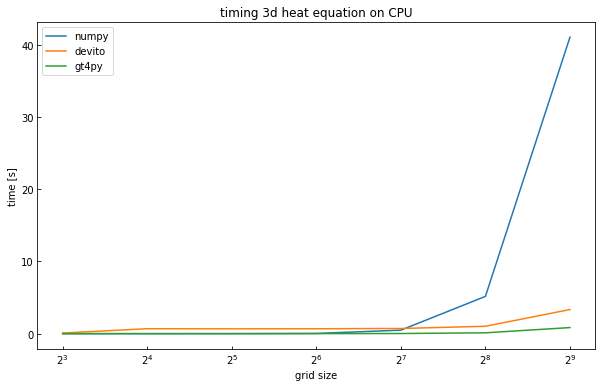

In [14]:
fig,ax = plt.subplots(figsize=(10,6))
ax.tick_params(direction='in')
ax.set(xlabel='grid size', ylabel='time [s]',
       title='timing 3d heat equation on CPU')
ax.set_xscale('log', basex=2)
plt.plot(x, time_np, label='numpy')
plt.plot(x, time_devito, label='devito')
plt.plot(x, time_gt4py, label='gt4py')
ax.legend()

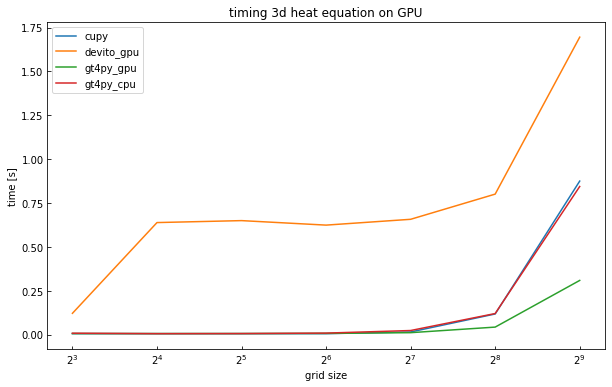

In [15]:
fig,ax = plt.subplots(figsize=(10,6))
ax.tick_params(direction='in')
ax.set(xlabel='grid size', ylabel='time [s]',
       title='timing 3d heat equation on GPU')
ax.set_xscale('log', basex=2)
plt.plot(x, time_cp, label='cupy')
plt.plot(x, time_devito_gpu, label='devito_gpu')
plt.plot(x, time_gt4py_gpu, label='gt4py_gpu')
plt.plot(x, time_gt4py, label='gt4py_cpu')
ax.legend()